In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This is derived from RunModel_Demo_02June2020-SimpleCNNLayer_Ca

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.

The 04Feb2021 version of the code is intended to train the same model, but using the KDE_A kernels rather than the original kernels.  The purpose is to test the code that reads in the KDE.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Feb  5 20:20:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   35C    P8    39W / 250W |   5636MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path


### Set up local parameters

In [4]:
n_epochs = 50


folder = '05February2021_AllCNN6Layer_Ca_iter1_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 1e-3

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


##from model.models_mds_G import SimpleCNN5Layer_Ca as Model
from model.models_mds_G import AllCNN6Layer_Ca as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features

train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                                 '/share/lazy/will/data/June30_2020_80k_2.h5',
                                 '/share/lazy/will/data/June30_2020_80k_3.h5',
                                 '/share/lazy/will/data/June30_2020_80k_4.h5',
                            batch_size=batch_size,
                           ## device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                           ## device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )



Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 12.71 s
Loaded /share/lazy/will/data/June30_2020_80k_2.h5 in 12.22 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 12.25 s
Loaded /share/lazy/will/data/June30_2020_80k_4.h5 in 12.11 s
Constructing 320000 event dataset took 0.875 s
Loading data...
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 3.055 s
Constructing 20000 event dataset took 0.08483 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Dropout(p=0.15, inplace=False)
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.35, inplace=False)
ct, child =  10    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))


In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
d_name = '05February2021_AllCNN6Layer_Ca_iter0_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill'
d_folder = d_name
suffix = 'final'
dict_name = 'ML/'+d_folder+'/'+d_name+'_'+suffix+'.pyt'
print("pretrained dict_name = ",dict_name)
pretrained_dict = torch.load(dict_name)


model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/05February2021_AllCNN6Layer_Ca_iter1_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill
pretrained dict_name =  ML/05February2021_AllCNN6Layer_Ca_iter0_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill/05February2021_AllCNN6Layer_Ca_iter0_50epochs_poca_KDE_A_lr_1em3_loss_1p0_4xwill_final.pyt
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    finalFilter.weight
index, k =   11    finalFilter.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv

<All keys matched successfully>

In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


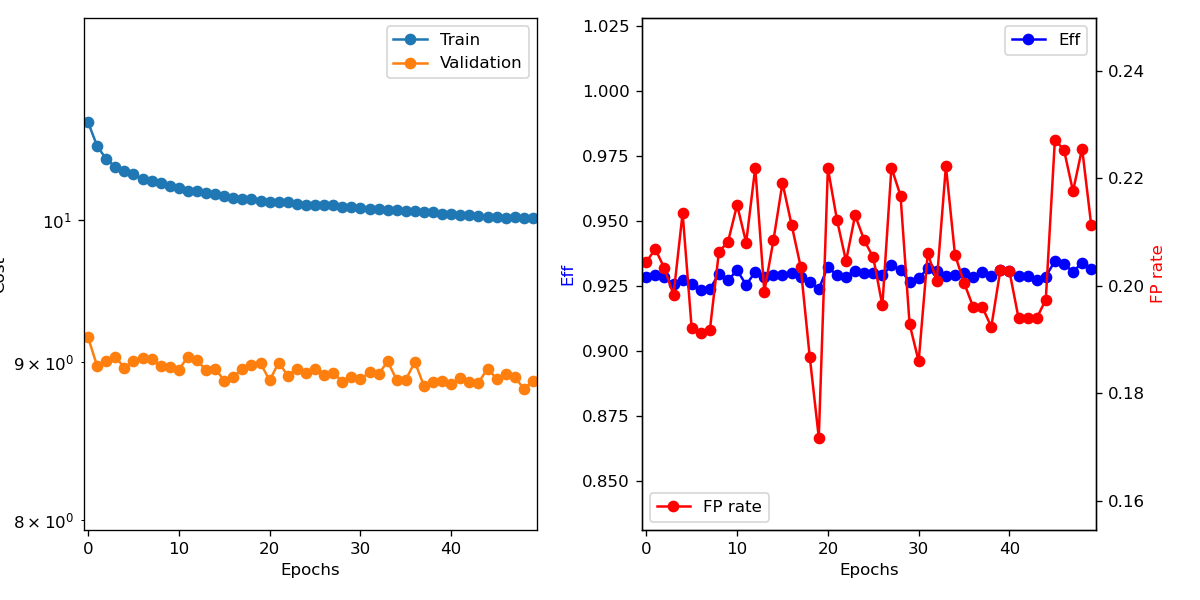

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 2500, val = 157


Epoch 0: train=10.758, val=9.16604, took 63.046 s
  Validation Found 100286 of 108007, added 4090 (eff 92.85%) (0.204 FP/event)


Epoch 1: train=10.5692, val=8.97164, took 63.991 s
  Validation Found 100349 of 108007, added 4137 (eff 92.91%) (0.207 FP/event)


Epoch 2: train=10.4667, val=9.00728, took 63.406 s
  Validation Found 100272 of 108007, added 4065 (eff 92.84%) (0.203 FP/event)


Epoch 3: train=10.4073, val=9.03232, took 63.928 s
  Validation Found 99990 of 108007, added 3967 (eff 92.58%) (0.198 FP/event)


Epoch 4: train=10.3712, val=8.96134, took 64.583 s
  Validation Found 100168 of 108007, added 4271 (eff 92.74%) (0.214 FP/event)


Epoch 5: train=10.3485, val=9.00676, took 64.548 s
  Validation Found 100004 of 108007, added 3842 (eff 92.59%) (0.192 FP/event)


Epoch 6: train=10.3125, val=9.02505, took 64.785 s
  Validation Found 99748 of 108007, added 3826 (eff 92.35%) (0.191 FP/event)


Epoch 7: train=10.2994, val=9.01842, took 64.99 s
  Validation Found 99783 of 108007, added 3836 (eff 92.39%) (0.192 FP/event)


Epoch 8: train=10.2806, val=8.9714, took 64.977 s
  Validation Found 100417 of 108007, added 4127 (eff 92.97%) (0.206 FP/event)


Epoch 9: train=10.2558, val=8.96788, took 64.905 s
  Validation Found 100154 of 108007, added 4164 (eff 92.73%) (0.208 FP/event)


Epoch 10: train=10.2429, val=8.9473, took 65.051 s
  Validation Found 100563 of 108007, added 4301 (eff 93.11%) (0.215 FP/event)


Epoch 11: train=10.2225, val=9.03537, took 65.423 s
  Validation Found 99963 of 108007, added 4161 (eff 92.55%) (0.208 FP/event)


Epoch 12: train=10.2172, val=9.01281, took 65.599 s
  Validation Found 100493 of 108007, added 4440 (eff 93.04%) (0.222 FP/event)


Epoch 13: train=10.2056, val=8.94216, took 65.146 s
  Validation Found 100283 of 108007, added 3979 (eff 92.85%) (0.199 FP/event)


Epoch 14: train=10.1943, val=8.95341, took 64.804 s
  Validation Found 100362 of 108007, added 4169 (eff 92.92%) (0.208 FP/event)


Epoch 15: train=10.1804, val=8.87548, took 65.133 s
  Validation Found 100356 of 108007, added 4383 (eff 92.92%) (0.219 FP/event)


Epoch 16: train=10.1681, val=8.90019, took 65.112 s
  Validation Found 100439 of 108007, added 4228 (eff 92.99%) (0.211 FP/event)


Epoch 17: train=10.1586, val=8.95393, took 65.074 s
  Validation Found 100285 of 108007, added 4072 (eff 92.85%) (0.204 FP/event)


Epoch 18: train=10.1601, val=8.97633, took 64.24 s
  Validation Found 100073 of 108007, added 3737 (eff 92.65%) (0.187 FP/event)


Epoch 19: train=10.1479, val=8.99062, took 64.238 s
  Validation Found 99791 of 108007, added 3436 (eff 92.39%) (0.172 FP/event)


Epoch 20: train=10.1369, val=8.87575, took 64.23 s
  Validation Found 100713 of 108007, added 4438 (eff 93.25%) (0.222 FP/event)


Epoch 21: train=10.1364, val=8.99491, took 64.247 s
  Validation Found 100348 of 108007, added 4246 (eff 92.91%) (0.212 FP/event)


Epoch 22: train=10.1366, val=8.9078, took 64.995 s
  Validation Found 100302 of 108007, added 4092 (eff 92.87%) (0.205 FP/event)


Epoch 23: train=10.124, val=8.95461, took 64.848 s
  Validation Found 100552 of 108007, added 4263 (eff 93.10%) (0.213 FP/event)


Epoch 24: train=10.1165, val=8.92768, took 64.861 s
  Validation Found 100450 of 108007, added 4170 (eff 93.00%) (0.208 FP/event)


Epoch 25: train=10.1158, val=8.95169, took 65.11 s
  Validation Found 100435 of 108007, added 4106 (eff 92.99%) (0.205 FP/event)


Epoch 26: train=10.1114, val=8.91081, took 65.297 s
  Validation Found 100349 of 108007, added 3928 (eff 92.91%) (0.196 FP/event)


Epoch 27: train=10.1116, val=8.92795, took 65.138 s
  Validation Found 100779 of 108007, added 4440 (eff 93.31%) (0.222 FP/event)


Epoch 28: train=10.0998, val=8.86706, took 64.962 s
  Validation Found 100593 of 108007, added 4336 (eff 93.14%) (0.217 FP/event)


Epoch 29: train=10.0977, val=8.89779, took 64.663 s
  Validation Found 100086 of 108007, added 3858 (eff 92.67%) (0.193 FP/event)


Epoch 30: train=10.0932, val=8.88542, took 64.822 s
  Validation Found 100238 of 108007, added 3720 (eff 92.81%) (0.186 FP/event)


Epoch 31: train=10.0868, val=8.92882, took 64.883 s
  Validation Found 100639 of 108007, added 4121 (eff 93.18%) (0.206 FP/event)


Epoch 32: train=10.0816, val=8.91802, took 64.989 s
  Validation Found 100523 of 108007, added 4019 (eff 93.07%) (0.201 FP/event)


Epoch 33: train=10.0775, val=9.00332, took 64.924 s
  Validation Found 100317 of 108007, added 4446 (eff 92.88%) (0.222 FP/event)


Epoch 34: train=10.0752, val=8.87881, took 64.757 s
  Validation Found 100370 of 108007, added 4116 (eff 92.93%) (0.206 FP/event)


Epoch 35: train=10.0711, val=8.88135, took 65.01 s
  Validation Found 100443 of 108007, added 4012 (eff 93.00%) (0.201 FP/event)


Epoch 36: train=10.0664, val=8.9993, took 64.653 s
  Validation Found 100283 of 108007, added 3922 (eff 92.85%) (0.196 FP/event)


Epoch 37: train=10.0606, val=8.83979, took 64.854 s
  Validation Found 100474 of 108007, added 3922 (eff 93.03%) (0.196 FP/event)


Epoch 38: train=10.0609, val=8.86804, took 64.668 s
  Validation Found 100322 of 108007, added 3848 (eff 92.88%) (0.192 FP/event)


Epoch 39: train=10.0506, val=8.87013, took 64.763 s
  Validation Found 100584 of 108007, added 4060 (eff 93.13%) (0.203 FP/event)


Epoch 40: train=10.0445, val=8.85437, took 65.114 s
  Validation Found 100543 of 108007, added 4054 (eff 93.09%) (0.203 FP/event)


Epoch 41: train=10.041, val=8.8897, took 64.953 s
  Validation Found 100316 of 108007, added 3881 (eff 92.88%) (0.194 FP/event)


Epoch 42: train=10.0402, val=8.86712, took 64.817 s
  Validation Found 100344 of 108007, added 3879 (eff 92.91%) (0.194 FP/event)


Epoch 43: train=10.0305, val=8.86212, took 65.016 s
  Validation Found 100162 of 108007, added 3880 (eff 92.74%) (0.194 FP/event)


Epoch 44: train=10.028, val=8.95343, took 64.673 s
  Validation Found 100304 of 108007, added 3949 (eff 92.87%) (0.197 FP/event)


Epoch 45: train=10.025, val=8.88816, took 64.66 s
  Validation Found 100949 of 108007, added 4542 (eff 93.47%) (0.227 FP/event)


Epoch 46: train=10.017, val=8.91833, took 64.869 s
  Validation Found 100819 of 108007, added 4507 (eff 93.34%) (0.225 FP/event)


Epoch 47: train=10.0271, val=8.89684, took 64.854 s
  Validation Found 100503 of 108007, added 4352 (eff 93.05%) (0.218 FP/event)


Epoch 48: train=10.019, val=8.82249, took 64.271 s
  Validation Found 100880 of 108007, added 4511 (eff 93.40%) (0.226 FP/event)


Epoch 49: train=10.0148, val=8.87064, took 64.273 s
  Validation Found 100622 of 108007, added 4228 (eff 93.16%) (0.211 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')
results.to_hdf(str(output / f'{name}_stats_a.hdf5'),'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


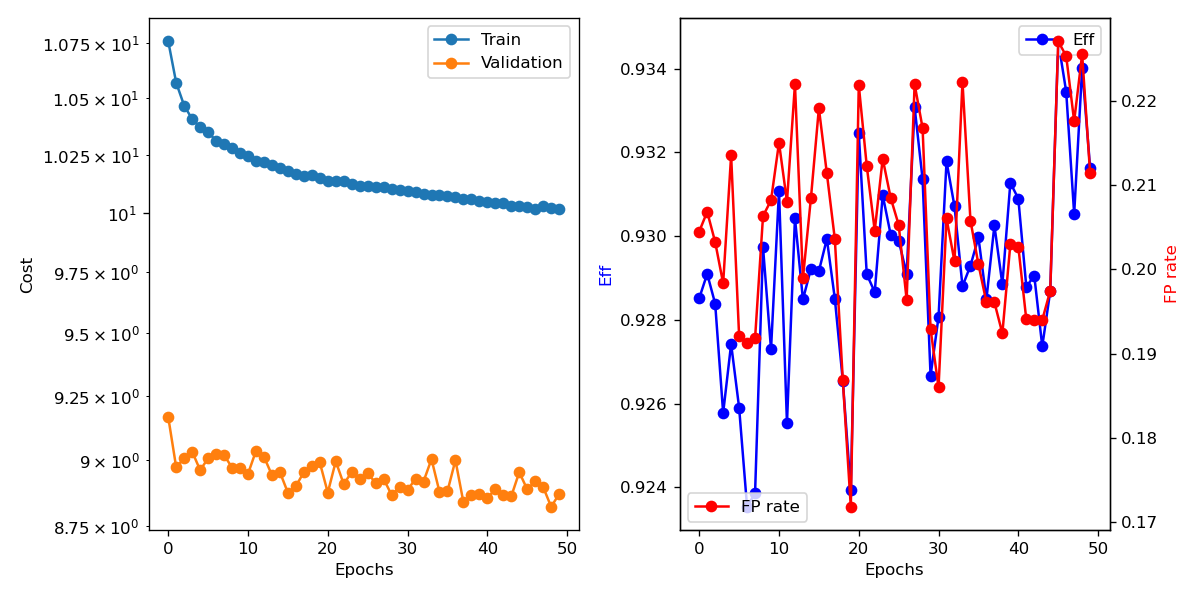

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [1]:
##quit()